In [1]:
%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
import mechanize
from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

In [2]:
sfdmap.__file__

'C:\\Users\\serat\\anaconda4\\Lib\\site-packages\\sfdmap.py'

# Data

In [3]:
file_path = 'ascii/J14301603+2303445_2023-01-06_COS.dat'

t = Table.read(file_path, format='ascii', delimiter='\s', header_start=3, data_start=5)

column_names = ['Wavelength', 'F_lambda', 'e_F_lambda']

original_colnames = t.colnames

for original, new in zip(original_colnames, column_names):
    t.rename_column(original, new)
    
t.sort('Wavelength')

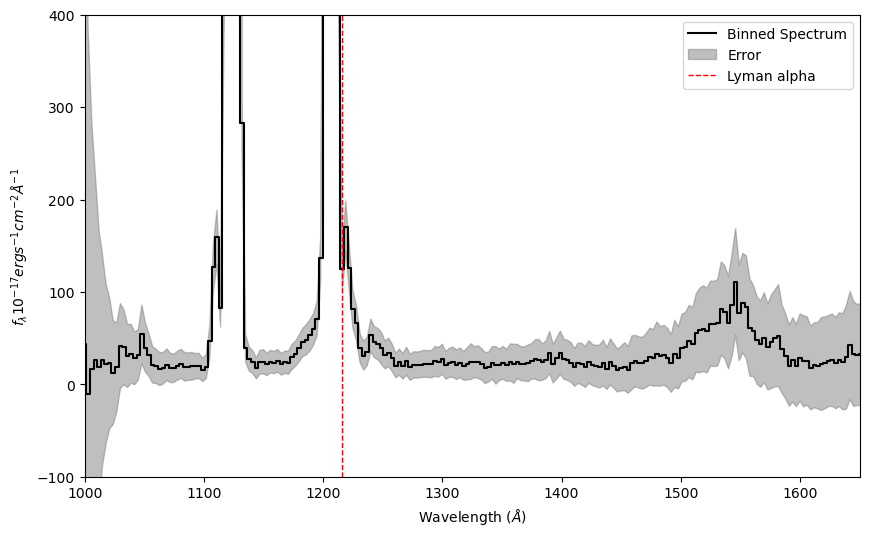

In [4]:
z = 0.081


bin_width = 3

bins = np.arange(min(t["Wavelength"]), max(t["Wavelength"]) + bin_width, bin_width)
bin_centers = 0.5 * (bins[:-1] + bins[1:])

indices = np.digitize(t["Wavelength"], bins)

binned_wl = []
binned_flux = []
binned_flux_err = []


for i in range(1, len(bins)):
    in_bin = indices == i
    if np.any(in_bin):
        binned_wl.append(np.mean(t["Wavelength"][in_bin]))
        binned_flux.append(np.mean(t["F_lambda"][in_bin]))
        binned_flux_err.append(np.mean(t["e_F_lambda"][in_bin]))
    else:
        pass

binned_wl = np.array(binned_wl)
binned_flux = np.array(binned_flux)
binned_flux_err = np.array(binned_flux_err)

plt.figure(figsize=(10, 6))
plt.plot(binned_wl, binned_flux, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1000, 1650)
plt.ylim(-100, 400)
plt.legend()
plt.show()

In [5]:
print(t)

    Wavelength     F_lambda e_F_lambda
------------------ -------- ----------
  650.447359111158      0.0        0.0
 650.5211771965372      0.0        0.0
 650.5949952819166      0.0        0.0
 650.6688133672958      0.0        0.0
  650.742631452675      0.0        0.0
 650.8164495380544      0.0        0.0
 650.8902676234337      0.0        0.0
  650.964085708813      0.0        0.0
 651.0379037941923      0.0        0.0
 651.1117218795716      0.0        0.0
               ...      ...        ...
1858.9970529409065      0.0        0.0
 1859.070871026286      0.0        0.0
1859.1446891116652      0.0        0.0
1859.2185071970443      0.0        0.0
 1859.292325282424      0.0        0.0
 1859.366143367803      0.0        0.0
1859.4399614531824      0.0        0.0
1859.5137795385617      0.0        0.0
 1859.587597623941      0.0        0.0
1859.6614157093202      0.0        0.0
1859.7352337946998      0.0        0.0
Length = 16383 rows


In [6]:
mask1 = np.where((binned_wl < 1100) | (binned_wl > 1145))
lam = binned_wl[mask1]
flux_red = binned_flux[mask1]
err  = binned_flux_err[mask1]

#lam = binned_wl
#flux_red = binned_flux
#err  = binned_flux_err
mask2 = np.where((lam < 1190) | (lam > 1240))
lam = lam[mask2]
flux_red = flux_red[mask2]
err  = err[mask2]


err[np.where(err==np.inf)] = np.max(err[np.where(err!=np.inf)])

lam = np.nan_to_num(lam)
flux_red = np.nan_to_num(flux_red)
err = np.nan_to_num(err)

In [7]:
# download spectrum from SDSS
path_dust = 'C:/Users/serat/Downloads/sfddata-master/'
ra  = 217.5668392
dec =23.06236944
z   = 0.081

In [8]:
# deredden the spectrum

lam = lam*(1+z)
m   = sfdmap.SFDMap(path_dust)
ebv = m.ebv(ra, dec)
Av  = 3.1*ebv
zero_flux  = np.where(flux_red == 0, True, False)
flux_red[zero_flux] = 1e-10
flux = extinction.remove(extinction.fitzpatrick99(lam.astype('double'),Av, 3.1),flux_red)
err_unred  = err*flux/flux_red
flux[zero_flux] = 0
err_unred[zero_flux] = 0

lam = lam/(1+z)

(-100.0, 400.0)

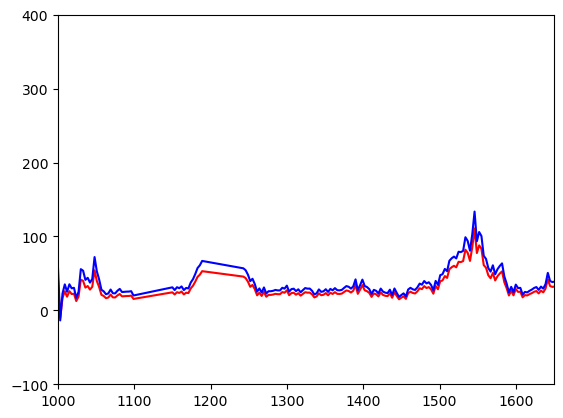

In [9]:
plt.plot(lam, flux_red, 'r')
plt.plot(lam, flux, 'b')
plt.xlim(1000, 1650)
plt.ylim(-100, 400)


## Functions

In [10]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [11]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [12]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [13]:
# Need to change for UV

def uv_agn_spectrum(wave_to_fit,pl_s,pl_e,\
                    #ly1_f,ly1_cent,ly1_fwhm,\
                    #ly2_f,ly2_cent,ly2_fwhm,\
                    o1_f,o1_cent,o1_fwhm,\
                    o2_f,o2_cent,o2_fwhm,\
                    #o3_f,o3_cent,o3_fwhm,\
                    #o4_f,o4_cent,o4_fwhm,\
                    #o5_f,o5_cent,o5_fwhm,\
                    si1_f,si1_cent,si1_fwhm,\
                    civ1_f,civ1_cent,civ1_fwhm,\
                    civ2_f,civ2_cent,civ2_fwhm,\
                         return_components=False,return_hyperfine_components=False):
    """
    Calculates a full optical AGN spectral model.
    """
    
    #x = wave_to_fit.to_value()
    x = np.array(wave_to_fit)
    y = np.zeros_like(x)
    
    # powerlaw
    pl = powerlaw(x,pl_s,pl_e)
    
    # uv Ly alph template
    #ly1 = gaussian(x,ly1_f,ly1_cent,ly1_fwhm,normalized=False)
    #ly2 = gaussian(x,ly2_f,ly2_cent,ly2_fwhm,normalized=False)
    
    # uv Ly alph template
    o1 = gaussian(x,o1_f,o1_cent,o1_fwhm,normalized=False)
    o2 = gaussian(x,o2_f,o2_cent,o2_fwhm,normalized=False)
    #o3 = gaussian(x,o3_f,o3_cent,o3_fwhm,normalized=False)
    #o4 = gaussian(x,o4_f,o4_cent,o4_fwhm,normalized=False)
    #o5 = gaussian(x,o5_f,o5_cent,o5_fwhm,normalized=False)
    
    # uv Si I template
    si1 = gaussian(x,si1_f,si1_cent,si1_fwhm,normalized=False)
    
    # uv C IV template
    civ1 = gaussian(x,civ1_f,civ1_cent,civ1_fwhm,normalized=False)
    civ2 = gaussian(x,civ2_f,civ2_cent,civ2_fwhm,normalized=False)
    
   
    y = pl + si1 + o1 + o2 + civ1 + civ2
    
    
    if return_components:
        y = {'model':y,\
             'pl':pl,\
             #'ly1':ly1,\
             #'ly2':ly2,\
             'o1':o1,\
             'o2':o2,\
             #'o3':o3,\
             #'o4':o4,\
             #'o5':o5,\
             'si1':si1,\
             'civ1': civ1,\
             'civ2':civ2}  
    
    return y

In [14]:
def pl_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(plaw, 2,
            parnames=['scale','power'], 
            parlimited=[(False,False),(False,False)], 
            parlimits=[(0,0),(0,0)], 
            shortvarnames=('S','P')
            )
    myclass.__name__ = "pl"
    
    return myclass

In [15]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [16]:
# Need to change

def uv_agn_fitter(order=1):
    """
    Generator for powerlaw fitter class
    """

    myclass =  pyspeckit.models.model.SpectralModel(uv_agn_spectrum, 17,
            parnames=['pl_s','pl_e',\
                      #'ly1_f', 'ly1_cent', 'ly1_fwhm',\
                      #'ly2_f', 'ly2_cent', 'ly2_fwhm',\
                      'o1_f', 'o1_cent', 'o1_fwhm',\
                      'o2_f', 'o2_cent', 'o2_fwhm',\
                      #'o3_f', 'o3_cent', 'o3_fwhm',\
                      #'o4_f', 'o4_cent', 'o4_fwhm',\
                      #'o5_f', 'o5_cent', 'o5_fwhm',\
                      'si1_f', 'si1_cent', 'si1_fwhm',\
                      'civ1_f', 'civ1_cent', 'civ1_fwhm',\
                      'civ2_f', 'civ2_cent', 'civ2_fwhm'], 
            parlimited=[(False,False),(False,False),\
                        #(False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        #(False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False),\
                        (False,False), (False,False), (False,False)], 
            parlimits=[(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       #(0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0),\
                       (0,0),(0,0),(0,0)]
            )
    myclass.__name__ = "uvagn"
    
    return myclass

In [17]:
def plot_uv_agn_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    #ly1 = model['ly1']+model['ly2']
    #o1 = model['o1']+model['o2']+model['o3']+model['o4']+model['o5']
    o1 = model['o1']
    o2 = model['o2']
    si1 = model['si1']
    civ_broad = model['civ1']
    civ_narrow = model['civ2']
    
    
    
    fig = plt.figure(figsize=(18, 6))
    ax  = plt.axes()
    ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    ax.plot(wave,model['model'],color=indian_red,lw=2)
    ax.plot(wave,model['pl'],color=royal_blue)
    #ax.plot(wave,o1,color=turquoise)
    #ax.plot(wave,o2,color=salmon)
    #ax.plot(wave,si1,color=turquoise)
    #ax.plot(wave,civ_broad,color=turquoise)
    #ax.plot(wave,civ_narrow,color=salmon)
    ax.set_xlim(wavemin,wavemax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()
    if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)
    
    #fig = plt.figure(figsize=(18, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,flux-model['model'],color=indian_red,lw=2)
    #ax.set_xlim(wavemin,wavemax)
    #ax.set_ylim(ymin,ymax)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()
    #if HARDCOPY: fig.savefig(plotfile+'_fullfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    
    
    ##fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1100,1150)
    #ax.set_ylim(-100, 400)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_CIVfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1100, 1150)
    #ax.set_ylim(0, 62000)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1140, 1300)
    #ax.set_ylim(-100, 400)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    #
    #fig = plt.figure(figsize=(8, 6))
    #ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ##ax.plot(wave,ly1,color=pink)
    ##ax.plot(wave,o1,color=pink)
    ##ax.plot(wave,si1,color=pink)
    ##ax.plot(wave,civ,color=pink)
    #ax.set_xlim(1140, 1250)
    #ax.set_ylim(0, 6000)
    #ax.set_xlabel(xlabel,size=24)
    #ax.set_ylabel(ylabel,size=24)
    #plt.tight_layout()  
    #if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    #if SHOW: plt.show()
    #plt.close(fig)
    
    
    
    

## Setup for plotting

In [18]:
# SETUP 
##############################################################
##############################################################
fontfamily = 'Times New Roman'
matplotlib.rcParams['font.family'] = fontfamily
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble']=r"\usepackage{amsmath}"
plt.rc('xtick.major',pad=2)
plt.rc('ytick.major',pad=2)
plt.rc('xtick.minor',pad=2)
plt.rc('ytick.minor',pad=2)
plt.rc('xtick', labelsize=24)
plt.rc('ytick', labelsize=24)
plt.rc('font',size=24,weight='bold')
plt.rcParams['axes.labelweight'] = 'bold'

blood_orange = [204/255,17/255,0/255]
indian_red = [176/255,23/255,31/255]
indian_red = [200/255,23/255,31/255]
green = [0/255,205/255,0/255]
dark_orange = [255/255,127/255,0/255]
goldenrod = [255/255,193/255,37/255]
midnight_blue = [25/255,25/255,112/255]
transparent_blue = [138/255,181/255,220/255]
gray = [130/255,130/255,130/255]
dark_gray = [50/255,50/255,50/255]
salmon = [250/255,128/255,114/255]
royal_blue = [0/255,0/255,200/255]
turquoise  = [0/255,204/255,204/255]
cyan  = [0/255,255/255,255/255]
pink = [255/255,0/255,127/255]
med_pink = [191/255, 0/255, 96/255]
dark_pink = [128/255, 0/255, 64/255]

## Set up emission lines

This sets emission lines and some offsets between them.

In [19]:
# set up the relevant emission lines
z = 0.081

ly = 1216
o1_e_o = 1200
nv = 1239.85
ly_e = 1216.25/(1+z)
o1_e = 1305.42/(1+z)
si = 1398.33
c4 = 1546.15
print(ly_e, o1_e)

line_off = o1_e/ly_e

c = 2.99e5 # km/s

1125.1156336725255 1207.604070305273


## Fit parameters from a rough spectral decomposition

Do a very rough spectral decomposition to the H$\beta$ region in order to get some guesses for starting parameters in this regime.

This creates a "continuum subtracted" spectrum by subtracting a hardcoded value, then fits Gaussians and saves their best-fit values to use as a starting guess later. It won't work on any other spectrum because of the continuum subtraction.

In [20]:
# Need to change
guesses = [5, 0,\
           #62500, ly_e, 2000,\
           #200, ly_e-15, 2000,\
           40, o1_e-15, 5000,\
           30, o1_e+35, 3000,\
           #13.6, o1_e-15, 2000,\
           #200, ly, 3000,\
           #70, o1_e_o, 10000,\
           #30, nv, 5000,\
           20, si, 5000,\
           40, c4, 5000,\
           40, c4, 2000]

step = [0.5, 0.05,\
        #0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        #0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5,\
        0.5, 0.1, 5]
           
tied = ['','',\
        #'','','',\
        #'','','',\
        '','','',\
        '','','',\
        #'','p[3]*{0}'.format(line_off),'p[4]',\
        #'p[5]*p[8]/p[2]','p[6]*{0}'.format(line_off),'p[7]',\
        #'','','',\
        #'','','',\
        #'','','',\
        '','','',\
        '','','',\
        '','','']

fixed = [0,0,\
         #0,0,0,\
         #0,0,0,\
         0,0,0,\
         0,0,0,\
         #0,0,0,\
         #0,0,0,\
         #0,0,0,\
         0,0,0,\
         0,0,0,\
         0,0,0]

In [21]:
# this actually does the fit after resetting the spectrum
spec = pyspeckit.Spectrum(data=flux, xarr=lam,error=err)
spec.unit = 'erg s$^{-1}$ cm$^{-2}$ $\\AA^{-1}$'
spec.xarr.set_unit = u.angstrom #'$\\AA$'
spec.xarr.xtype='angstrom'
spec.Registry.add_fitter('uvagn',uv_agn_fitter(),17)
spec.specfit.selectregion(xmin=1300,xmax=1650)
spec.specfit(fittype='uvagn',vheight=False,guesses=guesses,tied=tied,fixed=fixed,parsteps=step,maxiter=500,baseline=False,subtract_baseline=False,quiet=False)

INFO: Left region selection unchanged.  xminpix, xmaxpix: 184,302 [pyspeckit.spectrum.interactive]
Iter       1    CHI-SQUARE =  112.6843993  DOF =  101
   PL_S0 = 5  
   PL_E0 = 0  
   O1_F0 = 40  
   O1_CENT0 = 1192.60407  
   O1_FWHM0 = 5000  
   O2_F0 = 30  
   O2_CENT0 = 1242.60407  
   O2_FWHM0 = 3000  
   SI1_F0 = 20  
   SI1_CENT0 = 1398.33  
   SI1_FWHM0 = 5000  
   CIV1_F0 = 40  
   CIV1_CENT0 = 1546.15  
   CIV1_FWHM0 = 5000  
   CIV2_F0 = 40  
   CIV2_CENT0 = 1546.15  
   CIV2_FWHM0 = 2000  
Iter       2    CHI-SQUARE =  80.91003141  DOF =  101
   PL_S0 = 6.37381148  
   PL_E0 = -0.8262413772  
   O1_F0 = 40  
   O1_CENT0 = 1192.60407  
   O1_FWHM0 = 5000  
   O2_F0 = 30  
   O2_CENT0 = 1242.60407  
   O2_FWHM0 = 3000  
   SI1_F0 = 20.91204815  
   SI1_CENT0 = 1398.139655  
   SI1_FWHM0 = 5427.16257  
   CIV1_F0 = 43.62434852  
   CIV1_CENT0 = 1545.876095  
   CIV1_FWHM0 = 5744.641353  
   CIV2_F0 = 42.48797138  
   CIV2_CENT0 = 1546.177364  
   CIV2_FWHM0 = 2206.906977  
I

Iter      23    CHI-SQUARE =  3.36576343  DOF =  101
   PL_S0 = 27.25654468  
   PL_E0 = 0.05661554207  
   O1_F0 = 40  
   O1_CENT0 = 1192.60407  
   O1_FWHM0 = 5000  
   O2_F0 = 30  
   O2_CENT0 = 1242.60407  
   O2_FWHM0 = 3000  
   SI1_F0 = 8.231266329  
   SI1_CENT0 = 1392.243449  
   SI1_FWHM0 = 5240.148404  
   CIV1_F0 = 60.05838679  
   CIV1_CENT0 = 1539.861167  
   CIV1_FWHM0 = 11937.2035  
   CIV2_F0 = 28.96098107  
   CIV2_CENT0 = 1548.219484  
   CIV2_FWHM0 = 2350.499728  
Iter      24    CHI-SQUARE =  3.365763429  DOF =  101
   PL_S0 = 27.25679897  
   PL_E0 = 0.05666590123  
   O1_F0 = 40  
   O1_CENT0 = 1192.60407  
   O1_FWHM0 = 5000  
   O2_F0 = 30  
   O2_CENT0 = 1242.60407  
   O2_FWHM0 = 3000  
   SI1_F0 = 8.230535801  
   SI1_CENT0 = 1392.245318  
   SI1_FWHM0 = 5241.453429  
   CIV1_F0 = 60.05843142  
   CIV1_CENT0 = 1539.861173  
   CIV1_FWHM0 = 11937.30965  
   CIV2_F0 = 28.96107111  
   CIV2_CENT0 = 1548.219448  
   CIV2_FWHM0 = 2350.533901  
Iter      25    CH

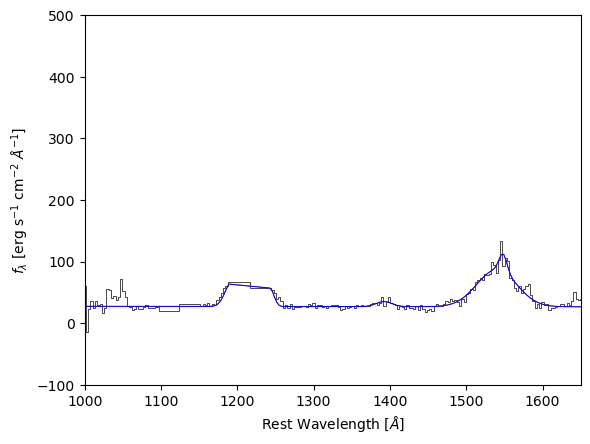

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
spec.plotter(xmin=1000,xmax=1650,ymin=-100,ymax=500,xlabel='Rest Wavelength [$\AA$]',ylabel="$f_{\lambda}$ [erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$]")
spec.specfit.plot_fit(annotate=False)
spec.specfit.plot_components()
plt.show()

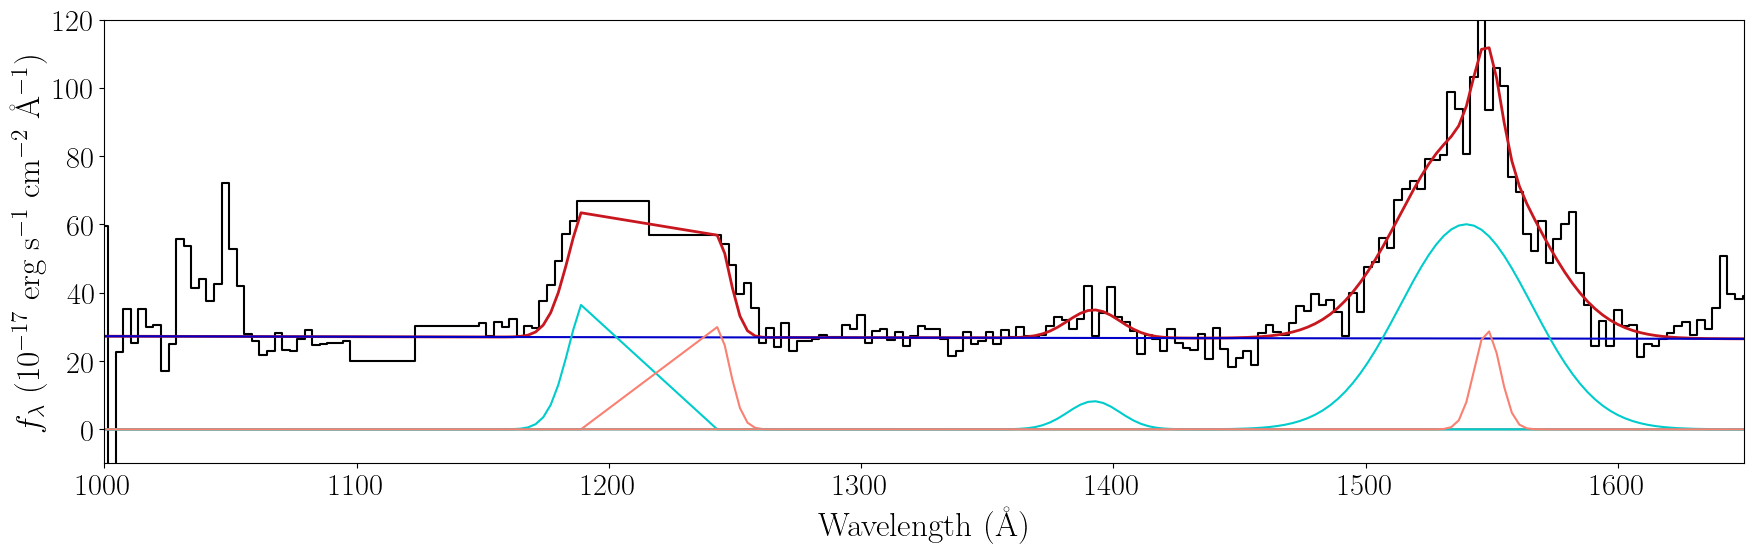

In [23]:
best_model = uv_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = 'uv2'
HARDCOPY = False
SHOW = True
plt.rc('text', usetex=True)
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 22
})

plot_uv_agn_fit(lam,flux,best_model,1000,1650,-10,120,'Wavelength (\AA)',\
                     '$f_{\lambda}$ (10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)',\
                     plotfile,HARDCOPY=True,SHOW=True)

In [24]:
def plot_ly1_o1_fit(wave,flux,model,wavemin,wavemax,ymin,ymax,xlabel,ylabel,plotfile,HARDCOPY=False,SHOW=True):
    ly1 = model['ly1']+model['ly2']
    o1 = model['o1']+model['o2']
    wave1 = wave * ly_e/o1_e
    
    fig = plt.figure(figsize=(8, 6))
    ax  = plt.axes()
    #ax.plot(wave,flux,drawstyle='steps-mid',color='black')
    #ax.plot(wave,model['model'],color=indian_red,lw=2)
    #ax.plot(wave,model['pl'],color=royal_blue)
    ax.plot(wave,ly1/max(ly1),color=pink)
    ax.plot(wave1,o1/max(o1),color=pink)
    print(max(ly1), max(o1))
    
    ax.set_xlim(1100, 1150)
    ax.set_ylim(0, 1.1)
    ax.set_xlabel(xlabel,size=24)
    ax.set_ylabel(ylabel,size=24)
    plt.tight_layout()  
    if HARDCOPY: fig.savefig(plotfile+'_plfit.pdf', format='pdf')
    if SHOW: plt.show()
    plt.close(fig)




best_model = uv_agn_spectrum(lam,*spec.specfit.parinfo.values,return_components=True)
wavemin = 1000.
wavemax = 1650.
ymin = -100.
ymax = 400.
wave = lam
flux = flux
model = best_model
xlabel = 'Wavelength $[\AA]$'
ylabel = '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]'
plotfile = '../plots/j0950/plots/spec-52509-0902-0498'
HARDCOPY = False
SHOW = True

plot_ly1_o1_fit(lam,flux,best_model,1000,1650,-100,400,'Wavelength $[\AA]$',\
                     '$f_\lambda$ [10$^{-17}$ erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$]',\
                     plotfile,HARDCOPY=False,SHOW=True)

KeyError: 'ly1'

# Other Visualizations

In [ ]:


# set up the relevant emission lines
z = 0.081



ly = 1216
o1_e_o = 1200
nv = 1239.85
ly_e = 1216.25/(1+z)
o1_e = 1305.42/(1+z)
si = 1398.33
c4 = 1546.15
print(ly_e, o1_e)

line_off = o1_e/ly_e

c = 2.99e5 # km/s


wl = np.array(t["Wavelength"])
fx = np.array(t["F_lambda"])
fx_e = np.array(t["e_F_lambda"])

max_ly1 = np.max(fx[np.where((wl < 1150) & (wl > 1100))[0]])
max_o1 = np.max(fx[np.where((wl < 1300) & (wl > 1150))[0]])

fx_ly1 = fx/max_ly1
fx_o1 = fx/max_o1

wl_ly1 = wl
wl_o1 = wl* (ly_e/o1_e)


plt.figure(figsize=(10, 6))
plt.plot(wl_ly1, fx_ly1, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.plot(wl_o1, fx_o1, label='Binned Spectrum', color="black", drawstyle='steps-mid')
##plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
##plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1100, 1150)
plt.ylim(-1, 1.2)
plt.legend()
plt.show()


bin_width = 2

bins_ly1 = np.arange(min(wl_ly1), max(wl_ly1) + bin_width, bin_width)
bin_centers_ly1 = 0.5 * (bins_ly1[:-1] + bins_ly1[1:])
#
indices_ly1 = np.digitize(wl_ly1, bins_ly1)
#
binned_wl_ly1 = []
binned_fx_ly1 = []
binned_fx_e = []
#
#
for i in range(1, len(bins_ly1)):
    in_bin_ly1 = indices_ly1 == i
    if np.any(in_bin_ly1):
        binned_wl_ly1.append(np.mean(wl_ly1[in_bin_ly1]))
        binned_fx_ly1.append(np.mean(fx_ly1[in_bin_ly1]))
#        binned_flux_err.append(np.mean(fx_err_ly1[in_bin_ly1]))
    else:
        pass
#
binned_wl_ly1 = np.array(binned_wl_ly1)
binned_fx_ly1 = np.array(binned_fx_ly1)



bins_o1 = np.arange(min(wl_o1), max(wl_o1) + bin_width, bin_width)
bin_centers_o1 = 0.5 * (bins_o1[:-1] + bins_o1[1:])
#
indices_o1 = np.digitize(wl_o1, bins_o1)
#
binned_wl_o1 = []
binned_fx_o1 = []
binned_fx_e = []
#
#
for i in range(1, len(bins_o1)):
    in_bin_o1 = indices_o1 == i
    if np.any(in_bin_o1):
        binned_wl_o1.append(np.mean(wl_o1[in_bin_o1]))
        binned_fx_o1.append(np.mean(fx_o1[in_bin_o1]))
#        binned_flux_err.append(np.mean(fx_err_ly1[in_bin_ly1]))
    else:
        pass
#
binned_wl_o1 = np.array(binned_wl_o1)
binned_fx_o1 = np.array(binned_fx_o1)










plt.figure(figsize=(10, 6))
plt.plot(binned_wl_ly1, binned_fx_ly1, label='Binned Spectrum', color="black", drawstyle='steps-mid')
plt.plot(binned_wl_o1, binned_fx_o1, label='Binned Spectrum', color="black", drawstyle='steps-mid')
##plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
##plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")
plt.xlabel("Wavelength ($\AA$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(1100, 1150)
plt.ylim(-1, 1.2)
plt.legend()
plt.show()

#binned_flux_err = np.array(binned_fx_e)
#
#max_ly1 = np.max(binned_flux[np.where((binned_wl < 1150) & (binned_wl > 1100))[0]])
#max_o1 = np.max(binned_flux[np.where((binned_wl < 1300) & (binned_wl > 1150))[0]])
#
#print(max_ly1, max_o1)
#
#plt.figure(figsize=(10, 6))
#plt.plot(binned_wl, binned_flux/max_ly1, label='Binned Spectrum', color="black", drawstyle='steps-mid')
#plt.plot(binned_wl* (ly_e/o1_e), binned_flux/max_o1, label='Binned Spectrum', color="black", drawstyle='steps-mid')
##plt.fill_between(binned_wl, binned_flux - binned_flux_err, binned_flux + binned_flux_err, color='gray', alpha=0.5, label='Error')
##plt.axvline(x=1216, color='r', linestyle='--', linewidth=1, label="Lyman alpha")
#plt.xlabel("Wavelength ($\AA$)")
#plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
#plt.xlim(1100, 1150)
#plt.ylim(-1, 1.2)
#plt.legend()
#plt.show()


In [ ]:


# set up the relevant emission lines
z = 0.081



ly = 1216
o1_e_o = 1200
nv = 1239.85
ly = 1216.25
ly_e = ly/(1+z)
o1 = 1305.42
o1_e = o1/(1+z)
si = 1398.33
c4 = 1546.15
print(ly_e, o1_e)

line_off = o1_e/ly_e

c = 2.99e5 # km/s


wl = np.array(t["Wavelength"])
fx = np.array(t["F_lambda"])
fx_e = np.array(t["e_F_lambda"])

#wl_ly1 = wl
#wl_o1 = wl* (o1_e/ly_e)

v_ly1 = c * ((wl - ly_e) / ly_e)
v_o1 = c * ((wl - o1_e) / o1_e)

print(o1_e)


max_ly1 = np.max(fx[np.where((v_ly1 < 10000) & (v_ly1 > -10000))[0]])
max_o1 = np.max(fx[np.where((v_o1 < 10000) & (v_o1 > -10000))[0]])



fx_ly1 = fx/max_ly1
fx_o1 = fx/max_o1




plt.figure(figsize=(10, 6))
plt.plot(v_ly1, fx_ly1, label='Ly Spectrum', color="black", drawstyle='steps-mid')
plt.plot(v_o1, fx_o1, label='O Spectrum', color="red", drawstyle='steps-mid')
plt.xlabel("Velocity ($v$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(-10000, 10000)
plt.ylim(-1, 1.2)
plt.legend()
plt.show()








bin_width = 5

# Ly1


bins_ly1 = np.arange(min(v_ly1), max(v_ly1) + bin_width, bin_width)
bin_centers_ly1 = 0.5 * (bins_ly1[:-1] + bins_ly1[1:])
indices_ly1 = np.digitize(v_ly1, bins_ly1)
binned_v_ly1 = []
binned_fx_ly1 = []

for i in range(1, len(bins_ly1)):
    in_bin_ly1 = indices_ly1 == i
    if np.any(in_bin_ly1):
        binned_v_ly1.append(np.mean(v_ly1[in_bin_ly1]))
        binned_fx_ly1.append(np.mean(fx_ly1[in_bin_ly1]))

    else:
        pass

binned_v_ly1 = np.array(binned_v_ly1)
binned_fx_ly1 = np.array(binned_fx_ly1)



# O1

bins_o1 = np.arange(min(v_o1), max(v_o1) + bin_width, bin_width)
bin_centers_o1 = 0.5 * (bins_o1[:-1] + bins_o1[1:])

indices_o1 = np.digitize(v_o1, bins_o1)

binned_v_o1 = []
binned_fx_o1 = []

for i in range(1, len(bins_o1)):
    in_bin_o1 = indices_o1 == i
    if np.any(in_bin_o1):
        binned_v_o1.append(np.mean(v_o1[in_bin_o1]))
        binned_fx_o1.append(np.mean(fx_o1[in_bin_o1]))
    else:
        pass

binned_v_o1 = np.array(binned_v_o1)
binned_fx_o1 = np.array(binned_fx_o1)




plt.figure(figsize=(10, 6))
plt.plot(binned_v_ly1, binned_fx_ly1, label='Binned Ly Spectrum', color="black", drawstyle='steps-mid')
plt.plot(binned_v_o1, binned_fx_o1, label='Binned O Spectrum', color="red", drawstyle='steps-mid')
plt.xlabel("Velocity ($v$)")
plt.ylabel("$f_{\lambda} 10^{-17} erg s^{-1} cm^{-2} \AA^{-1}$")
plt.xlim(-5000, 5000)
plt.ylim(-1, 1.2)
plt.legend()
plt.show()

